In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [5]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from plots import *

In [95]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
from seaborn.apionly import set_palette
from IPython.display import set_matplotlib_formats

# configure plotting
set_matplotlib_formats('pdf', 'svg')
set_palette('Set1', n_colors=15, desat=None)

In [6]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [7]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict

[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [8]:
feature_name
rho = 0.05
rho_string = "_rho0pt05-normalized"
lag_time=10
n_clusters=1000

In [9]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A


In [12]:
ligand_residue = Residue(resSeq=900, chain_id="L", res_name="LIG")

In [13]:
ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=900, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [ ]:
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, bp_residue_objects)]

In [ ]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=user_specified_atom_residue_pairs, worker_pool=dview, excluded_trajs=["apo"])

In [15]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [ ]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True)

In [16]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 178.90922359,  143.68868462,  109.99061648,   78.28258235,
         58.0406239 ,   56.40792161,   45.351805  ,   37.9696193 ,
         30.85374593,   26.86710215])

In [17]:
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(3, 7)
residue_importances_df.shape
(5, 3)
        feature_name       res_i   res_j  resid_i  resid_j  importance  \
1   Lig900-O2-Cys321   Lig900-O2  Cys321      900      321    0.550781   
0   Lig900-O1-Ile234   Lig900-O1  Ile234      900      234   -0.386844   
2  Lig900-C26-Ile234  Lig900-C26  Ile234      900      234    0.276101   

                feature  
1   (Lig900-O2, Cys321)  
0   (Lig900-O1, Ile234)  
2  (Lig900-C26, Ile234)  
               residue  importance  resid
Cys321          Cys321    0.550781    321
Lig900-O2    Lig900-O2    0.550781    900
Lig900-O1    Lig900-O1   -0.386844    900
Lig900-C26  Lig900-C26    0.276101    900
Ile234          Ile234    0.242954    234
Interpreting tIC 2
feature_importances_df.sha

In [74]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

tic_subsampled_features_file = "%s/features_subsampled.pkl" % tica_dir
print tic_subsampled_features_file
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file)

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/features_subsampled.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_reimaged_rep_109.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_reimaged_rep_1.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_reimaged_rep_129.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_reimaged_rep_149.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_reimaged_rep_119.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_reimaged_rep_179.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dk

(Lig900-N1, Tyr75)
(Lig900-O1, Ile298)


57

In [ ]:
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", structures = [active_ref_dir, inactive_ref_dir], contact_residue_pairs_file = feature_residues_pkl, dihedral_residues =  [], dihedral_types = ["phi", "psi", "chi1", "chi2"], contact_residues =  contact_residues, residues_map = None, contact_cutoff = cutoff, exacycle = False, load_from_file=True)
if not os.path.exists(features_dir): os.makedirs(features_dir)
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", structures = [active_ref_dir, inactive_ref_dir], contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=user_specified_atom_residue_pairs, worker_pool=dview, excluded_trajs=["apo"])

fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=load_feature_parallel, traj_ext = traj_ext)


In [ ]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["BU72_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [35]:
bu72_trajs = []
apo_trajs = []
for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "bu72" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [66]:
protein_tica_file = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"
protein_tica = verboseload(protein_tica_file)
protein_tica_bu72 = [protein_tica[i] for i in bu72_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...












loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_64.datasetloading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_54.datasetloading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_235.datasetloading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_225.datasetloading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_34.datasetloading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_245.datasetloading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_under_cutoff6A/bu72_rep_94.da

In [110]:
protein_tica_bu72_conc = np.concatenate(protein_tica_bu72)
ligand_tica_bu72_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...


In [ ]:
import plots
reload(plots)
from plots import *

plot_data_vs_data(protein_tica_bu72_conc, ligand_tica_bu72_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["BU72_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [46]:
n_clusters = 1000
clusterer_dir = "%s/bu72clusterer_%dclusters.h5" % (tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir, tICs=list(range(0,10)))

Already clustered


In [44]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,26,5)))

In [113]:
lag_time = 10
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
#build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [114]:
from msm_resampled import *

In [88]:
bu72_pp_resampled_traj_to_frames_file = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_msm_lag-time20_prior-counts0.0_clusters1000_resampled.h5"
bu72_pp_resampled_traj_to_frames = verboseload(bu72_pp_resampled_traj_to_frames_file)
bu72_pp_msm_file = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_msm_lag-time20_prior-counts0.0_clusters1000.h5"
bu72_pp_msm = verboseload(bu72_pp_msm_file)
bu72_pp_clusterer = verboseload('/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_clusterer1000.h5')
bu72_pp_clusters_map = make_clusters_map(bu72_pp_clusterer)
bu72_pp_projection_operator_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/phi_psi_chi2_allprot_tica_coords.h5"
bu72_pp_tic_components_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized"
bu72_pp_tica_dir = bu72_pp_tic_components_dir
bu72_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
bu72_pp_tic_subsampled_features = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/features_subsampled.pkl"

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_msm_lag-time20_prior-counts0.0_clusters1000_resampled.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_msm_lag-time20_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_clusterer1000.h5"...
256
2
91
122
149
580
150
201
83
510
83
53
462
83
283
19
449
153
476
258
99
794
41
195
214
344
366
385
1
272
257
174
51
360
274
172
255
484
15
74
241
163
550
187
301
345
326
124
1413
161
46
205
134
1341
952
251
382
1135
381
1579
1439
0
8
109
717
83
165
112
475
0
215
101
63
141
13
253
170
575
195
56
57
22
1437
28
258
368
0
0
163
1
79
27

In [213]:
tica_coords = verboseload(projected_features_dir)
bu72_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"
bu72_pnas = verboseload(bu72_pnas_file)
bu72_tica_file = '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_tica.h5'
bu72_tica = verboseload(bu72_tica_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_tica.h5"...


In [214]:
bu72_pnas_dfs = []
for array in bu72_pnas:
    bu72_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
bu72_tica_dfs = []
for array in bu72_tica:
    bu72_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]))
    

In [212]:
tica

NameError: name 'tica' is not defined

In [178]:
feature_name_residues_dict

{'res_277_res_339_ca_dist': [R277, R339],
 'rmsd_DRY_active': [R165, R279, R252],
 'rmsd_DRY_inactive': [R165, R279, R252],
 'rmsd_npxxy_active': [R332, R333, R334, R335, R336],
 'rmsd_npxxy_inactive': [R332, R333, R334, R335, R336],
 'rmsd_triad_active': [R289, R244, R155],
 'rmsd_triad_inactive': [R289, R244, R155],
 'tm6_tm3_dist': [R279, R165],
 'tm6_tm3_packing': [[R158,
   R159,
   R160,
   R161,
   R162,
   R163,
   R164,
   R165,
   R166,
   R167,
   R168],
  [R274, R275, R276, R277, R278, R279, R280, R281, R282, R283, R284, R285]],
 'tm6_tm7_packing': [[R332,
   R333,
   R334,
   R335,
   R336,
   R337,
   R338,
   R339,
   R340,
   R341],
  [R274, R275, R276, R277, R278, R279, R280, R281, R282, R283, R284, R285]]}

In [47]:
bu72_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5")
cluster_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_pnas)
cluster_averages = pd.DataFrame(cluster_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.2) & (cluster_averages["rmsd_npxxy_active"] < 0.25) & (cluster_averages["tm6_tm3_packing"] > 12.75) & (cluster_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_averages["tm6_tm3_packing"] > 8.0) & (cluster_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
[  0   5   8  14  18  21  25  27  33  34  46  47  48  50  53  58  59  64
  73  74  78  82 100 103 109 116 119 121 129 134 136 139 141 147 149 156
 157 160 170 171 177 179 189 191 192 216 220 221 227 229 233 237 255 256
 257 258 260 263 275 281 282 287 295 301 304 314 335 336 340 342 343 344
 347 350 351 352 354 358 360 361 362 363 364 365 368 377 382 383 384 385
 389 395 396 403 404 406 410 413 419 421 422 423 424 452 461 466 469 474
 476 482 483 490 491 493 498 512 519 520 523 526 529 534 537 543 552 555
 556 559 560 561 563 572 573 579 581 592 596 605 607 616 625 627 628 640
 642 658 659 662 664 666 667 672 673 679 680 692 694 696 701 702 710 711
 713 720 725 726 729 736 738 743 744 745 746 753 755 759 762 763 776 779
 781 796 809 810 818 819 822 825 840 841 844 858 863 873 891 897 900 903
 904 910 916 928 936 939 945 957 962 964 965 966 968 973 974 977 978 984
 995 996 997 998]
[ 54  63 224 373 443 522 5

/home/enf/software/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [89]:
ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(bu72_pp_tic_subsampled_features)
protein_top_features = [protein_top_features[i] for i in bu72_trajs]

loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/features_subsampled.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/features_subsampled.pkl


In [22]:
interpret_tIC_components(bu72_pp_projection_operator_dir, bu72_pp_tic_components_dir, bu72_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(10, 7)
residue_importances_df.shape
(14, 3)
          feature_name      res_i      res_j  resid_i  resid_j  importance  \
0         Leu88-Phe338      Leu88     Phe338       88      338    0.230825   
8  Leu335_Ca-Phe338_Ca  Leu335_Ca  Phe338_Ca      335      338   -0.150707   
2         Asn86-Phe338      Asn86     Phe338       86      338    0.131836   
3        Val286-Tyr336     Val286     Tyr336      286      336    0.130005   
5  Val334_Ca-Phe338_Ca  Val334_Ca  Phe338_Ca      334      338    0.122108   
9  Leu339_Ca-Tyr336_Ca  Leu339_Ca  Tyr336_Ca      339      336   -0.120023   
7  Leu335_Ca-Leu339_Ca  Leu335_Ca  Leu339_Ca      335      339    0.103351   
1        Val282-Gly253     Val282     Gly253      282      253    0.073

[(ASN104_CA, THR97_CA),
 (ASN230, PHE221),
 (MET99_CA, CYS346_CA),
 (ASN86_CA, PRO333_CA),
 (VAL92_CA, LYS98_CA),
 (CYS79, TYR326),
 (VAL89_CA, PRO333_CA),
 (LYS98, ASN104),
 (ALA111_CA, PRO333_CA),
 (LEU339, LEU283),
 (THR97_CA, ARG95_CA),
 (LEU339, VAL284),
 (ASN86_CA, TYR336_CA),
 (ILE290, ILE248),
 (THR279_CA, MET281_CA),
 (LEU110, PHE289),
 (GLU341_CA, ARG280_CA),
 (SER154, ASP114),
 (THR67, TYR128),
 (ILE322, TYR128),
 (VAL187, PHE156),
 (LEU158_CA, VAL286_CA),
 (TYR128_CA, TYR75_CA),
 (LEU88, PHE343),
 (VAL81_CA, SER329_CA),
 (TRP293_CA, GLY325_CA),
 (ASN328_CA, TRP293_CA),
 (LEU339_CA, ARG280_CA),
 (MET99, PHE108),
 (MET99_CA, TYR96_CA),
 (GLY85, VAL334),
 (PHE343, PRO333),
 (ILE69_CA, ILE71_CA),
 (TYR128, TRP318),
 (ASN342_CA, THR97_CA),
 (TYR96_CA, PHE347_CA),
 (LEU121_CA, TYR75_CA),
 (PHE241_CA, PHE289_CA),
 (GLY82, TYR326),
 (TRP293, ASP147),
 (VAL81, PRO333),
 (VAL89_CA, ALA337_CA),
 (LEU121, ASP147),
 (TYR128_CA, TYR326_CA),
 (VAL89_CA, TYR336_CA),
 (TYR326_CA, ASP147_CA)

In [97]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [bu72_pp_msm.mapping_[i] for i in active_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
sinks = [bu72_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
bu72_pp_tpt_paths_file = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_clusterer1000_tpt_paths.h5"
tpt_paths = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

[2, 41, 59, 61, 71, 116, 133, 148, 153, 195, 236, 239, 250, 267, 272, 277, 296, 352, 365, 375, 376, 384, 387, 430, 442, 490, 493, 517, 521, 522, 544, 551, 562, 680, 720, 743, 764, 767, 775, 779, 783, 808, 831, 834, 858, 896, 914]
[110, 275, 355, 421, 538, 567, 612]
([array([521, 580, 181, 421]), array([521, 580,   7, 421]), array([775, 152, 684, 181, 421]), array([521, 210, 580, 818, 181, 421]), array([521, 818,   7, 181, 421])], array([  1.02215691e-05,   9.85149591e-06,   7.53305611e-06,
         6.10885167e-06,   5.10688358e-06]))
path = [521 580 181 421]
path = [521 580   7 421]
path = [775 152 684 181 421]
path = [521 210 580 818 181 421]
path = [521 818   7 181 421]
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_clusterer1000_tpt_paths.h5"... (<type 'list'>)


In [207]:
n_steps = 10000
save_file = "%s/msm1000_clusters_t10_%d_steps.h5" % (bu72_pp_tica_dir, n_steps)
msm_traj_index_pairs = generate_msm_traj_index_series(bu72_pp_msm, int(active_clusters.index.values[0]), n_steps, bu72_pp_clusters_map, save_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/msm1000_clusters_t10_10000_steps.h5"... (<type 'list'>)


In [215]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:10000])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features, msm_traj_index_pairs[0:10000])
protein_msm_tica_traj = resample_features_by_msm_trajectory(bu72_tica_dfs, msm_traj_index_pairs[0:10000])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(bu72_pnas_dfs, msm_traj_index_pairs[0:10000])
bu72_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:10000])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj*10., protein_msm_featurized_traj*10., protein_msm_tica_traj, protein_msm_pnas_traj, bu72_msm_tica_traj])

we are operating on biox3


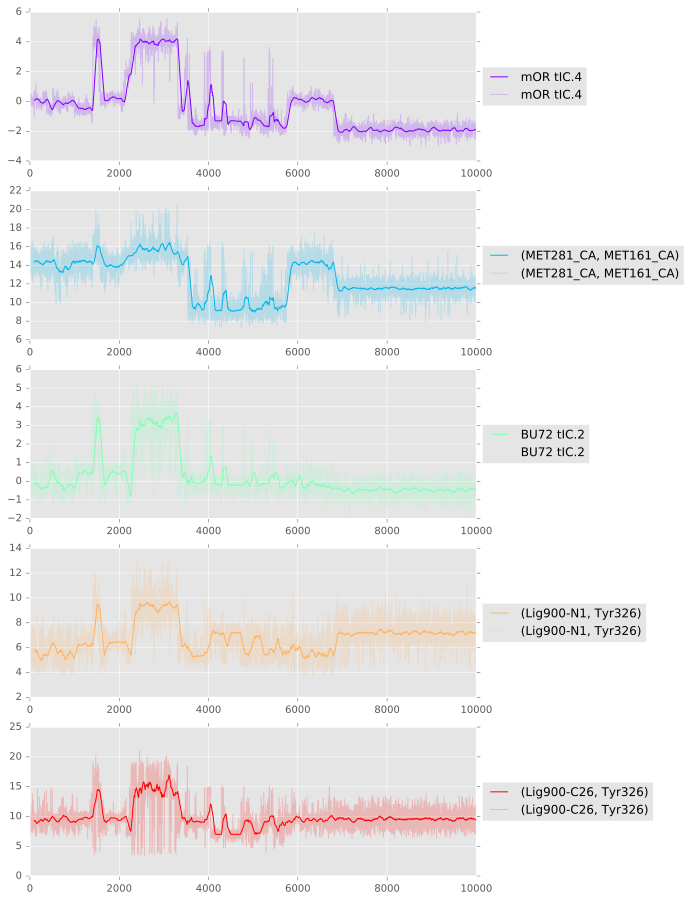

In [241]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()
feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]


feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.2" in name and "BU72" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "326" in name and "Lig900-N1" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "326" in name and "Lig900-C26" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "121" in name and "Lig900-N2" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements.png" %analysis_dir, True, smoothing=100, include_original=True)
plt.show()

In [229]:
"%s/key_measurements.pdf" %analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/key_measurements.pdf'

In [31]:
projected_features = verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
#resample_features_by_msm_equilibirum_pop(projected_features, bu72_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t10_n_components10bp_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt05-normalized/tica_msm_lag-time10_clusters1000_resampled.h5"...Currently analyzing mOR_tIC7, BU72_tIC9Currently analyzing mOR_tIC10, BU72_tIC9Currently analyzing mOR_tIC4, BU72_tIC9Currently analyzing mOR_tIC1, BU72_tIC9Currently analyzing mOR_tIC6, BU72_tIC10Currently analyzing mOR_tIC3, BU72_tIC10






Currently analyzing mOR_tIC2, BU72_tIC9Currently analyzing mOR_tIC7, BU72_tIC10Currently analyzing mOR_tIC10, BU72_tIC10




In [24]:
import plots
reload(plots)
from plots import *
bu72_pp_tica = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_tica_msm_lag-time20_prior-counts0.0_clusters1000_resampled.h5")
#plot_data_vs_data(tica_resampled, bu72_pp_tica, ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(bu72_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025-normalized/bu72_tica_msm_lag-time20_prior-counts0.0_clusters1000_resampled.h5"...
Currently analyzing mOR_tIC3, BU72_tIC2


In [35]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_BU72", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["BU72_tIC%d" %i for i in range(1,n_components+1)])

()
None
Done plotting columns
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
(2, 10001)
Computed 2D KDEComputed 2D KDE
Computed 2D KDEComputed 2D KDEComputed 2D KDE
Computed 2D KDEComputed 2D KDEComputed 2D KDEComputed 2D KDEComputed 2D KDE

Computed Density. Now plotting.

Computed Density. Now plotting.



Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.

(2, 10001)

(2, 10001)



(2, 10001)(2, 10001)
(2, 10001)(2, 10001)
(2, 10001)(2, 10001)(2, 10001)(2, 10001)

Computed 2D KDE


Computed 2D KDE




Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDEComputed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. 

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(bu72_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:


pearson_matrix = compute_pearson_matrix(bu72_pp_tica, tica_resampled)

In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
from seaborn.apionly import set_palette
from IPython.display import set_matplotlib_formats

# configure plotting
set_matplotlib_formats('pdf', 'svg')
set_palette('Set1', n_colors=15, desat=None)

In [ ]:
import matplotlib
matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

row_labels = ["BU72 tIC %d" %(i+1) for i in range(0,11)]
column_labels = ["mOR tIC %d" %(i+1) for i in range(0,11)]

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()


In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(bu72_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(bu72_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(bu72_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)